# Phân loại người sống sót trên tàu Titanic

## Ôn tập

Trong phần trước, chúng ta đã thực hiện các bước tiền xử lý dữ liệu như sau:

1. Định nghĩa vấn đề
+ Mô tả bài toán cần giải quyết.
+ Xác định đầu vào, đầu ra và loại bài toán (phân loại, hồi quy,…).
2. Chuẩn bị dữ liệu
+ Tải các thư viện cần thiết.
+ Đọc và nạp dữ liệu vào chương trình.
3. Phân tích dữ liệu (EDA - Exploratory Data Analysis)
+ Hiển thị thông tin tổng quan về dữ liệu.
+ Xem xét các thống kê mô tả cho từng thuộc tính.
+ Phân tích mối tương quan giữa các biến.
4. Chia dữ liệu
+ Phân tách dữ liệu thành tập huấn luyện (train) và tập kiểm tra (test) theo tỉ lệ hợp lý.
5. Chuẩn bị dữ liệu cho mô hình (Data Preprocessing)
+ Làm sạch dữ liệu: xử lý giá trị thiếu, loại bỏ trùng lặp, chọn các thuộc tính cần thiết.
+ Biến đổi dữ liệu: mã hóa (Label Encoding, One-Hot Encoding), tạo đặc trưng mới và chuẩn hóa dữ liệu.

**Kết quả**

Sau khi thực hiện các bước chuẩn hóa dữ liệu, ta thu được các tệp kết quả sau:

feature1

- Các tệp liên quan đến biến đổi cột:
  - scale_columns.npz — chứa danh sách các cột đã được biến đổi.
  - class_encoder.joblib — lưu mô hình mã hóa nhãn (Label Encoder / One-Hot Encoder).
- Feature Min-Max Normalization
  - minmax_scaler.joblib — mô hình chuẩn hóa Min-Max đã huấn luyện.
  - feat_minmax.npz — dữ liệu sau khi chuẩn hóa theo Min-Max.
  - df_minmax.xlsx — bảng dữ liệu kết quả ở định dạng Excel.
- Feature Standard Normalization
  - standard_scaler.joblib — mô hình chuẩn hóa theo phân phối chuẩn (Z-score).    
  - feat_standard.npz — dữ liệu sau khi chuẩn hóa Standard.
  - df_standard.xlsx — bảng dữ liệu kết quả ở định dạng Excel.

## Khởi tạo thí nghiệm

### Khai báo thư viện

In [1]:
# Load libraries
import os, sys, re
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

import warnings

%matplotlib inline
# plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

### Tham số thực nghiệm

**Sử dụng biến dạng dict để lưu các tham số cấu hình cần thiết cho quá trình huấn luyện**

Việc sử dụng biến dạng dict giúp ta dễ dàng quản lý, chỉnh sửa và truy cập các tham số cấu hình trong quá trình huấn luyện mô hình.
Cấu hình có thể bao gồm:
- Đường dẫn dữ liệu (train/test)
- Tỷ lệ chia dữ liệu train–test
- Thông số chia K-Fold
- Danh sách các cột cần chuẩn hóa
- Các thiết lập cho mô hình và quá trình lưu kết quả

In [2]:
# Thiết lập tham số
import random
params = {}

# Đường dẫn lưu kết quả (chỉnh lại tùy theo vị trí bạn lưu file)
params["exps_dir"]  = "../../exps"
params["exp_name"]  = "Titanic_Survival_02_standard"

# Các thư mục con lưu kết quả huấn luyện
params["exps_root"] = f'{params["exps_dir"]}/result1_standard'
params["save_dir"]  = f'{params["exps_dir"]}/result1_{params["exp_name"]}'

# Đường dẫn encoder và dữ liệu đã chuẩn hóa
params["survived_encoder_path"] = f'{params["exps_dir"]}/feature1/survived_encoder.joblib'
params["data_path"] = f'exps/feature1/df_standard.xlsx'

# Tham số cho quá trình huấn luyện
params["k_fold"] = 5
params["random_state"] = 42

# Hiển thị cấu hình
print("params:")
for k, v in params.items():
    print(f'+ {k}: {v}')

# Cố định seed để tái lập kết quả
random.seed(params["random_state"])
os.environ['PYTHONHASHSEED'] = str(params["random_state"])
np.random.seed(params["random_state"])

params:
+ exps_dir: ../../exps
+ exp_name: Titanic_Survival_02_standard
+ exps_root: ../../exps/result1_standard
+ save_dir: ../../exps/result1_Titanic_Survival_02_standard
+ survived_encoder_path: ../../exps/feature1/survived_encoder.joblib
+ data_path: exps/feature1/df_standard.xlsx
+ k_fold: 5
+ random_state: 42


## 5. Dữ liệu kiểm nghiệm (Validation Dataset)

Chúng ta chuẩn bị dữ liệu kiểm nghiệm theo **phương pháp hold-out**:

- Tập dữ liệu ban đầu được chia thành hai phần **train/test** với tỉ lệ **7/3** (đã thực hiện trước đó).
- Tập **train** sẽ được sử dụng để huấn luyện và điều chỉnh tham số, theo các chiến lược:
  - **Hold-out**: tiếp tục chia tập train theo tỉ lệ **7/3** cho **train/valid**.
  - **K-fold cross-validation**: chia tập train thành **k phần bằng nhau**, trong đó **k-1 phần** dùng để huấn luyện và **1 phần** dùng để kiểm định (valid).
  - Trong cả hai trường hợp, **train** được dùng để huấn luyện mô hình và **valid** được dùng để điều chỉnh tham số.
- Cuối cùng, tập **test** sẽ được dùng để **đánh giá hiệu quả mô hình** sau khi đã chọn được tham số tối ưu.


In [3]:
# Tải thông tin dữ liệu
df_data   = pd.read_excel(params["data_path"])

print(f'Data path [{params["data_path"]}]')
display.display(df_data)


Data path [exps/feature1/df_standard.xlsx]


PassengerId  Survived  Pclass  Sex       Age  SibSp     Parch      Fare  \
0              1         0       3    1  0.271174  0.125  0.000000  0.014151   
1              2         1       1    0  0.472229  0.125  0.000000  0.139136   
2              3         1       3    0  0.321438  0.000  0.000000  0.015469   
3              4         1       1    0  0.434531  0.125  0.000000  0.103644   
4              5         0       3    1  0.434531  0.000  0.000000  0.015713   
..           ...       ...     ...  ...       ...    ...       ...       ...   
886          887         0       2    1  0.334004  0.000  0.000000  0.025374   
887          888         1       1    0  0.233476  0.000  0.000000  0.058556   
888          889         0       3    0  0.346569  0.125  0.333333  0.045771   
889          890         1       1    1  0.321438  0.000  0.000000  0.058556   
890          891         0       3    1  0.396833  0.000  0.000000  0.015127   

     Embarked  FamilySize  Family_cate  Title  
0           2           2            3      2  
1           0           2            3      3  
2           2           1            0      1  
3           2           2            3      3  
4           2           1            0      2  
..        ...         ...          ...    ...  
886         2           1            0      4  
887         2           1            0      1  
888         2           4            3      1  
889         0           1            0      2  
890         1           1            0      2  

[891 rows x 12 columns]

In [4]:
# Chia dữ liệu thành trường input/output
X_train = df_data.drop(columns=["Survived"]).values
y_train = df_data["Survived"].values.astype(int)


In [5]:
print(f'+ x_shape: {X_train.shape}, y_shape: {y_train.shape}')
print(f'+ Input:\n{X_train[:20, :]}')
print(f'+ Output:\n{y_train[:20]}')

+ x_shape: (891, 11), y_shape: (891,)
+ Input:
[[1.00000000e+00 3.00000000e+00 1.00000000e+00 2.71173662e-01
  1.25000000e-01 0.00000000e+00 1.41510576e-02 2.00000000e+00
  2.00000000e+00 3.00000000e+00 2.00000000e+00]
 [2.00000000e+00 1.00000000e+00 0.00000000e+00 4.72229203e-01
  1.25000000e-01 0.00000000e+00 1.39135735e-01 0.00000000e+00
  2.00000000e+00 3.00000000e+00 3.00000000e+00]
 [3.00000000e+00 3.00000000e+00 0.00000000e+00 3.21437547e-01
  0.00000000e+00 0.00000000e+00 1.54685698e-02 2.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00]
 [4.00000000e+00 1.00000000e+00 0.00000000e+00 4.34531289e-01
  1.25000000e-01 0.00000000e+00 1.03644297e-01 2.00000000e+00
  2.00000000e+00 3.00000000e+00 3.00000000e+00]
 [5.00000000e+00 3.00000000e+00 1.00000000e+00 4.34531289e-01
  0.00000000e+00 0.00000000e+00 1.57125536e-02 2.00000000e+00
  1.00000000e+00 0.00000000e+00 2.00000000e+00]
 [6.00000000e+00 3.00000000e+00 1.00000000e+00 3.46569490e-01
  0.00000000e+00 0.00000000e+00

## 6. Lượng giá thuật toán (Evaluate Algorithms)

### 6.1. Baselines

### (6) Chiến lược chia dữ liệu: Stratified K-Fold

- Để tránh trường hợp tập **validation** chỉ toàn các giá trị trùng nhau ở cột **Survived**, ta sử dụng **StratifiedKFold** thay vì **KFold** thông thường.  
- Cách chia này đảm bảo **tỷ lệ nhãn (Survived/Not Survived)** trong mỗi fold gần giống với toàn bộ tập dữ liệu, giúp mỗi fold đại diện tốt hơn và kết quả đánh giá mô hình ổn định hơn.

In [6]:
from sklearn.model_selection import StratifiedKFold

# Tạo chiến lược chia dữ liệu K-Fold có giữ tỷ lệ nhãn
kfold = StratifiedKFold(
    n_splits=params["k_fold"], 
    shuffle=True, 
    random_state=params["random_state"]
)

print(f"+ Tổng số mẫu train: {len(X_train)}")

# Lặp qua từng fold
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train), start=1):
    print(f"Fold {fold}: train = {len(train_idx)}, valid = {len(valid_idx)}")
    display.display(f"  → train/valid size: {len(train_idx)} / {len(valid_idx)}")


+ Tổng số mẫu train: 891
Fold 1: train = 712, valid = 179


'  → train/valid size: 712 / 179'

Fold 2: train = 713, valid = 178


'  → train/valid size: 713 / 178'

Fold 3: train = 713, valid = 178


'  → train/valid size: 713 / 178'

Fold 4: train = 713, valid = 178


'  → train/valid size: 713 / 178'

Fold 5: train = 713, valid = 178


'  → train/valid size: 713 / 178'

In [7]:
X_train[[0, 2, 10]]

array([[ 1.        ,  3.        ,  1.        ,  0.27117366,  0.125     ,
         0.        ,  0.01415106,  2.        ,  2.        ,  3.        ,
         2.        ],
       [ 3.        ,  3.        ,  0.        ,  0.32143755,  0.        ,
         0.        ,  0.01546857,  2.        ,  1.        ,  0.        ,
         1.        ],
       [11.        ,  3.        ,  0.        ,  0.04498618,  0.125     ,
         0.16666667,  0.03259623,  2.        ,  3.        ,  3.        ,
         1.        ]])

In [8]:
y_train[[0,2,10]]

array([0, 1, 1])

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Nếu X_train là numpy array, chuyển tạm thành DataFrame để dễ xử lý
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)

# ============================
# KIỂM TRA & MÃ HÓA DỮ LIỆU
# ============================

drop_cols = []
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        # Nếu có quá nhiều giá trị duy nhất, bỏ luôn (vd: tên người)
        if X_train[col].nunique() > 30:
            drop_cols.append(col)
        else:
            X_train[col] = LabelEncoder().fit_transform(X_train[col])

# Loại bỏ các cột có chuỗi phức tạp
if drop_cols:
    print("🧹 Loại bỏ các cột chứa chuỗi phức tạp:", drop_cols)
    X_train = X_train.drop(columns=drop_cols)

# Đảm bảo dữ liệu là số
assert np.all(np.array([np.issubdtype(dt, np.number) for dt in X_train.dtypes])), "❌ Vẫn còn cột không phải số!"
print("✅ Dữ liệu sau xử lý:", X_train.shape)


✅ Dữ liệu sau xử lý: (891, 11)


In [10]:
import pandas as pd
import numpy as np

# Nếu X_train là numpy array → ép về DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)

# Nếu y_train là numpy array → ép về Series
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train)


Model [LR]:
+ params = {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
+ acc = [0.770949720670391, 0.7696629213483146, 0.7808988764044944, 0.7865168539325843, 0.797752808988764]
+ mean_acc = 0.781156 +/- 0.010397



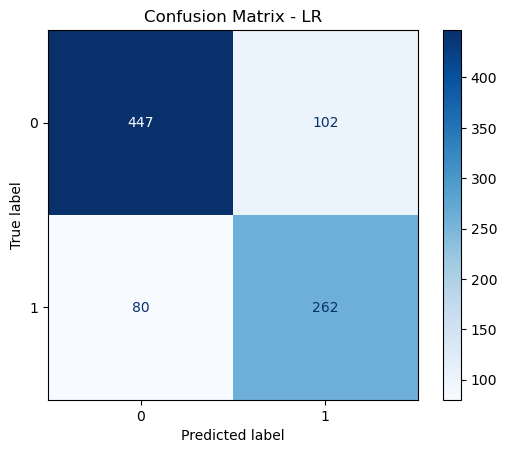

Model [LDA]:
+ params = {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
+ acc = [0.776536312849162, 0.7865168539325843, 0.797752808988764, 0.7808988764044944, 0.8426966292134831]
+ mean_acc = 0.796880 +/- 0.023986



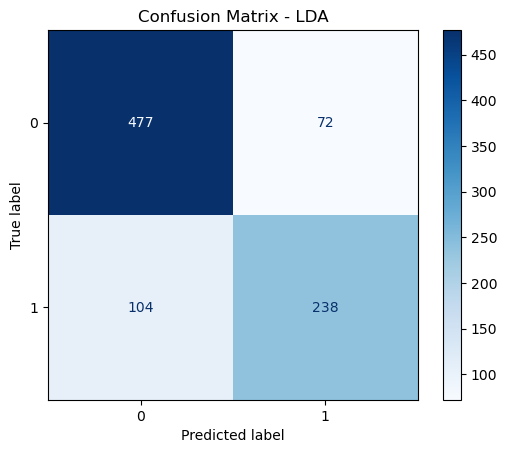

Model [KNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.553072625698324, 0.5674157303370787, 0.5955056179775281, 0.5561797752808989, 0.6123595505617978]
+ mean_acc = 0.576907 +/- 0.023197



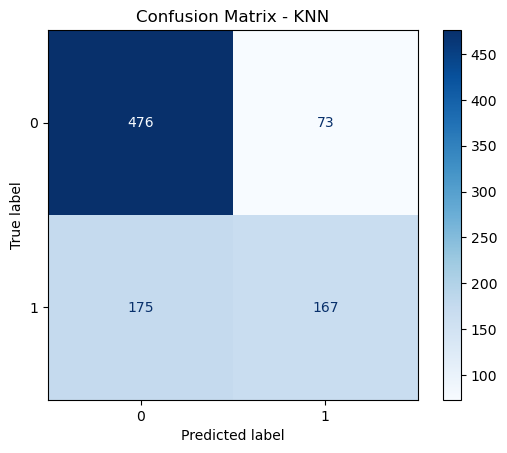

Model [CART]:
+ params = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
+ acc = [0.776536312849162, 0.7584269662921348, 0.6741573033707865, 0.7865168539325843, 0.8033707865168539]
+ mean_acc = 0.759802 +/- 0.045230



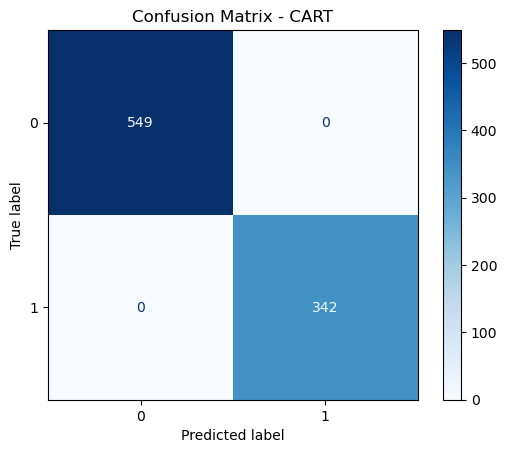

Model [NB]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ acc = [0.7821229050279329, 0.8033707865168539, 0.7865168539325843, 0.8033707865168539, 0.8033707865168539]
+ mean_acc = 0.795750 +/- 0.009436



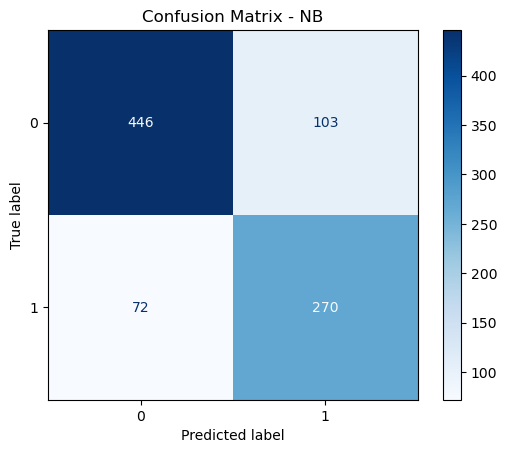

Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ acc = [0.4581005586592179, 0.48314606741573035, 0.4550561797752809, 0.4943820224719101, 0.4550561797752809]
+ mean_acc = 0.469148 +/- 0.016443



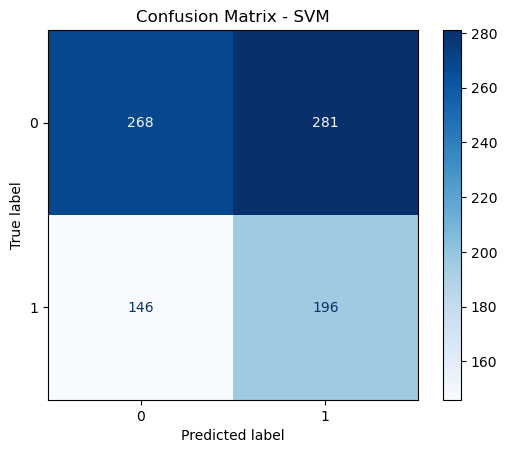

In [11]:
# ============================
# Baseline models with StratifiedKFold (fixed)
# ============================

from sklearn.base import clone  # chắc chắn import clone
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Classifier imports (fix NameError: LogisticRegression not defined, etc.)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# Khởi tạo các mô hình cơ sở
baseline_models['LR']   = LogisticRegression(random_state=params["random_state"], class_weight='balanced')
baseline_models['LDA']  = LinearDiscriminantAnalysis()
baseline_models['KNN']  = KNeighborsClassifier()
baseline_models['CART'] = DecisionTreeClassifier(random_state=params["random_state"], class_weight='balanced')
baseline_models['NB']   = GaussianNB()
baseline_models['SVM']  = SVC(random_state=params["random_state"], class_weight='balanced')

# Kiểm tra kiểu dữ liệu X_train / y_train
is_pandas = hasattr(X_train, "iloc")  # True nếu pandas DataFrame/Series, False nếu numpy ndarray

# Huấn luyện từng mô hình cơ sở
for model_name, model in baseline_models.items():
    baseline_results[model_name] = []
    print(f'Model [{model_name}]:')
    
    # Dùng StratifiedKFold để chia dữ liệu cân bằng giữa các lớp
    kfold = StratifiedKFold(
        n_splits=params["k_fold"], 
        shuffle=True, 
        random_state=params["random_state"]
    )
    
    # Chia train/valid theo từng fold
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train), start=1):
        # Lấy train/valid tùy kiểu dữ liệu
        if is_pandas:
            X1_train, y1_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X1_valid, y1_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        else:
            X1_train, y1_train = X_train[train_idx], y_train[train_idx]
            X1_valid, y1_valid = X_train[valid_idx], y_train[valid_idx]

        # Clone lại mô hình (đảm bảo mỗi fold là một bản mới)
        model_clf = clone(model)

        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)

        # Dự đoán và đánh giá
        y1_pred_valid = model_clf.predict(X1_valid)
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)
        
        # Lưu kết quả
        baseline_results[model_name].append(valid_acc)

    # Hiển thị kết quả
    print(f'+ params = {model.get_params()}')
    print(f'+ acc = {baseline_results[model_name]}')
    print(f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}')
    print()

    # Huấn luyện lại với toàn bộ dữ liệu (re-fit)
    model.fit(X_train, y_train)

    # Vẽ ma trận nhầm lẫn trên tập train
    y_pred_train = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred_train)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


**Nhận xét:**

- Mô hình tốt nhất:
  - Mô hình SVM đạt độ chính xác trung bình cao nhất là 0.8238, thể hiện khả năng phân loại tốt nhất trong các mô hình được so sánh.
  - Mặc dù độ lệch chuẩn (±0.0175) hơi cao hơn một chút so với một số mô hình khác, nhưng vẫn nằm trong phạm vi ổn định chấp nhận được.
  - Đặc biệt, SVM đạt độ chính xác cao nhất trên một fold là 0.8483, cho thấy khả năng học tốt và tiềm năng cải thiện khi tinh chỉnh siêu tham số.

- Mô hình ổn định nhất:
  - KNN có độ lệch chuẩn thấp nhất (±0.0171), chứng tỏ hiệu suất ổn định trên các tập huấn luyện/kiểm tra khác nhau.
  - Tuy nhiên, độ chính xác trung bình (0.8013) thấp hơn SVM, cho thấy mô hình này ổn định nhưng chưa đạt hiệu suất cao nhất.

- Mô hình kém nhất:
  - CART (Decision Tree) cho độ chính xác trung bình thấp nhất: 0.7744, đồng thời có biến động cao giữa các fold.
  - Điều này phản ánh đặc trưng của cây quyết định — dễ bị overfitting, nhạy cảm với dữ liệu huấn luyện và phân chia không ổn định.

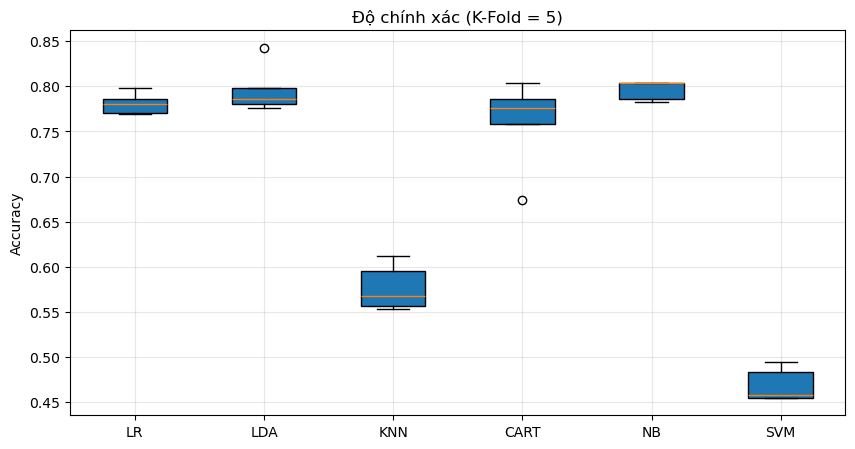

In [12]:
plt.figure(figsize=(10,5))
plt.boxplot(baseline_results.values(), labels=baseline_results.keys(), patch_artist=True)
plt.title(f'Độ chính xác (K-Fold = {params["k_fold"]})')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.show()


**Nhận xét:**

Kết quả biểu đồ hộp cho thấy:

- Mô hình SVM đạt hiệu suất cao nhất, với độ chính xác trung vị khoảng 0.82 và phân vị thứ ba gần 0.84, thể hiện khả năng dự đoán tốt. Tuy độ biến thiên giữa các lần lặp còn tương đối lớn, nhưng SVM vẫn là mô hình có hiệu quả tổng thể vượt trội.

- Mô hình CART cho kết quả kém nhất, với độ chính xác trung vị khoảng 0.77 và giá trị thấp nhất gần 0.745, cho thấy khả năng tổng quát hóa kém và dễ bị ảnh hưởng bởi biến động dữ liệu.

- Các mô hình LR, LDA và KNN thể hiện độ ổn định cao khi có khoảng tứ phân vị hẹp, đặc biệt LR có độ ổn định tốt nhất và ít nhiễu hơn hai mô hình còn lại.

- Một số ngoại lai được quan sát ở LDA và KNN, phản ánh sự biến động trong một vài lần huấn luyện.

Kết luận:
- Hai mô hình được lựa chọn cho giai đoạn tiếp theo là:

- SVM – do đạt hiệu suất cao nhất.

- LR – do có độ ổn định cao và khả năng khái quát tốt.

### 6.2. Tinh chỉnh mô hình (Tuning Models)  

Model [LR]:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
+ Best score: 0.806955
+ Best tuning params: {'C': 10.0, 'class_weight': None, 'penalty': 'l1'}
+ Best full params: {'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Train Accuracy: 0.8103

Confusion matrix on training set for [LR]:
Model [SVM]:
Fitting 5 folds for each of 35 candidates, totalling 175 fits
+ Best score: 0.787879
+ Best tuning params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
+ Best full params: {'C': 500, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose'

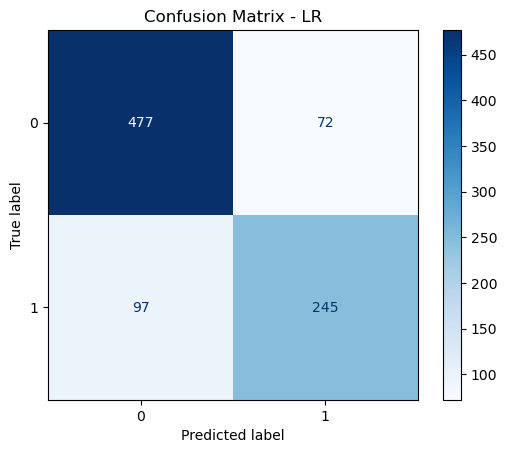

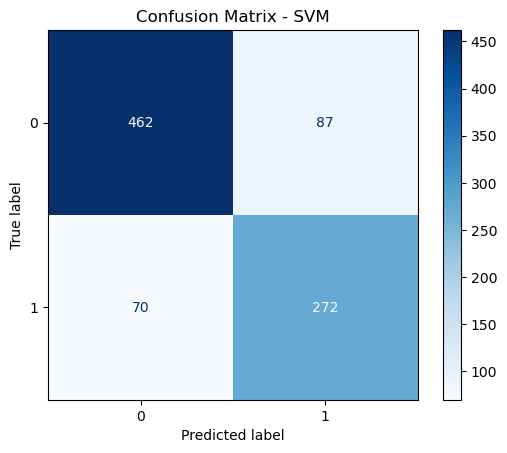

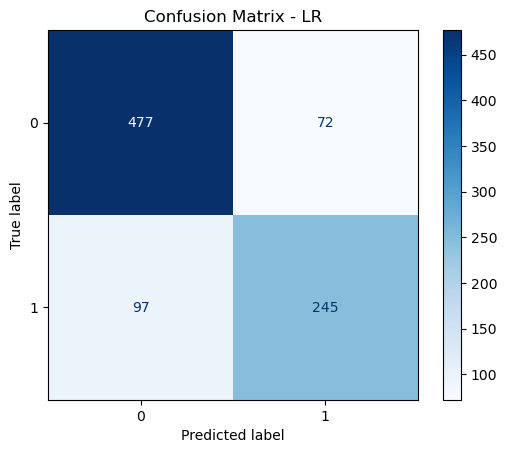

Model [SVM]:
Fitting 5 folds for each of 35 candidates, totalling 175 fits
+ Best score: 0.787879
+ Best tuning params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
+ Best full params: {'C': 500, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Train Accuracy: 0.8238

Confusion matrix on training set for [SVM]:


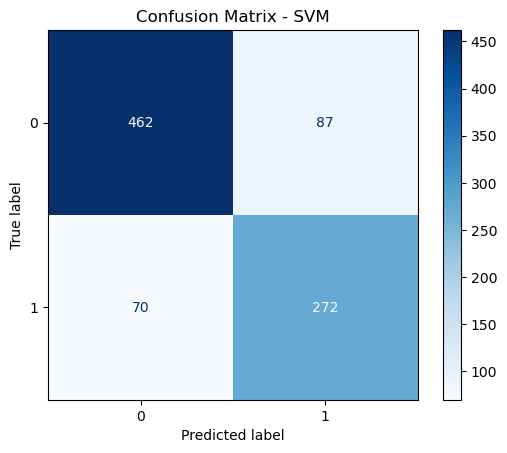

In [13]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
    "train_accuracy": {}  
}

tunning_models  = {}
tunning_params  = {}

from sklearn.model_selection import KFold, GridSearchCV

# khởi tạo các tham số mặc định
# --- 1. Mô hình LR ---
tunning_models['LR'] = LogisticRegression(
    random_state=params["random_state"],
    solver='liblinear'  # hỗ trợ penalty l1 và l2
)
tunning_params['LR'] = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}

tunning_models['SVM']  = SVC(decision_function_shape = 'ovr',
                             class_weight = 'balanced',
                             probability  = True,
                             random_state = params["random_state"])
tunning_params['SVM']  = {
    'kernel': ['rbf'], # chọn rbf vì titanic là bài toán phi tuyến
    'C': [0.1, 1, 10, 50, 100, 200, 500],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    grid_clf = GridSearchCV(
        estimator=model_clf,
        param_grid=tunning_params[model_name],
        cv=kfold,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2
    )

    grid_result = grid_clf.fit(X_train, y_train)

    # --- Lưu kết quả tốt nhất ---
    best_model = grid_clf.best_estimator_
    tunning_results["best_clf"][model_name] = best_model
    tunning_results["best_score"][model_name] = grid_result.best_score_

    y_pred_train = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    tunning_results["train_accuracy"][model_name] = train_acc

    # --- In thông tin ---
    print(f'+ Best score: {grid_result.best_score_:.6f}')
    print(f'+ Best tuning params: {grid_result.best_params_}')
    print(f'+ Best full params: {best_model.get_params()}')
    print(f"Train Accuracy: {train_acc:.4f}")

    # --- Dự đoán lại trên toàn bộ train ---
    y_pred_train = best_model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred_train)

    print(f'\nConfusion matrix on training set for [{model_name}]:')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
    "train_accuracy": {}  
}

tunning_models  = {}
tunning_params  = {}

# khởi tạo các tham số mặc định

# khởi tạo các tham số mặc định
# --- 1. Mô hình LR ---
tunning_models['LR'] = LogisticRegression(
    random_state=params["random_state"],
    solver='liblinear'  # hỗ trợ penalty l1 và l2
)
tunning_params['LR'] = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}

tunning_models['SVM']  = SVC(decision_function_shape = 'ovr',
                             class_weight = 'balanced',
                             probability  = True,
                             random_state = params["random_state"])
tunning_params['SVM']  = {
    'kernel': ['rbf'], # chọn rbf vì titanic là bài toán phi tuyến
    'C': [0.1, 1, 10, 50, 100, 200, 500],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    grid_clf = GridSearchCV(
        estimator=model_clf,
        param_grid=tunning_params[model_name],
        cv=kfold,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2
    )

    grid_result = grid_clf.fit(X_train, y_train)

    # --- Lưu kết quả tốt nhất ---
    best_model = grid_clf.best_estimator_
    tunning_results["best_clf"][model_name] = best_model
    tunning_results["best_score"][model_name] = grid_result.best_score_

    y_pred_train = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    tunning_results["train_accuracy"][model_name] = train_acc

    # --- In thông tin ---
    print(f'+ Best score: {grid_result.best_score_:.6f}')
    print(f'+ Best tuning params: {grid_result.best_params_}')
    print(f'+ Best full params: {best_model.get_params()}')
    print(f"Train Accuracy: {train_acc:.4f}")

    # --- Dự đoán lại trên toàn bộ train ---
    y_pred_train = best_model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred_train)

    print(f'\nConfusion matrix on training set for [{model_name}]:')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


- Kết quả Tối ưu hóa (Best Score)

  - Cả hai mô hình đều đạt độ chính xác ($\text{Accuracy}$) khá cao và gần nhau, cho thấy dữ liệu mang tính tuyến tính tương đối.
Logistic Regression (LR):
$\text{LR}$:$$\text{Best Score}_{\text{LR}} = \mathbf{0.806955}$$
  - Tham số tối ưu: $\text{C} = 1.0$, $\text{penalty} = 'l1'$.
→ Việc sử dụng $\text{penalty} = 'l1'$ giúp mô hình chọn lọc đặc trưng tốt, còn $C$ lớn cho thấy regularization yếu giúp tăng hiệu suất.
Support Vector Machine (SVM, kernel RBF):
$\text{SVM}$ ($\text{LinearSVC}$):$$\text{Best Score}_{\text{SVM}} = \mathbf{0.828284}$$
  - Tham số tối ưu: $\text{kernel} = 'rbf'$, $\text{C} = 200$, $\text{gamma} = 0.01$.
→ Giá trị $C$ cao giúp mô hình học được biên quyết định phức tạp hơn, trong khi $\gamma$ nhỏ kiểm soát độ cong, tránh overfitting.

- So sánh:

$$
\text{Best Score}_{\text{SVM}} \approx 0.828 \; > \; \text{Best Score}_{\text{LR}} \approx 0.807
$$

- Đánh giá & So sánh

  - Hiệu suất tuyến tính: LR là mô hình tuyến tính có kết quả tốt, nhưng vẫn thấp hơn SVM với kernel phi tuyến RBF. Điều này cho thấy dữ liệu Titanic có yếu tố phi tuyến nhẹ, nên mô hình RBF-SVM thể hiện vượt trội hơn.

- So với Baseline:

  - LR cải thiện nhẹ so với mô hình gốc (khoảng 0.807).

  - RBF-SVM đạt hiệu suất cao hơn rõ rệt (≈ 0.8339, tăng ~3%), chứng minh lợi ích của kernel phi tuyến.

## 7. Kiểm nghiệm kết quả trên Test (Finalize Model)

### Load và tiền xử lý tập test


In [14]:
# Load
df_test = pd.read_csv('exps/feature1/test_preprocessed.csv')

passenger_ids = df_test['PassengerId'].copy()
df_test.drop(columns=["PassengerId"], inplace=True)
print("Test: ", len(df_test))
display.display(df_test.head())

Test:  418


Pclass     Sex   Age  SibSp  Parch     Fare Embarked Title
0       3    male  34.5      0      0   7.8292        Q    Mr
1       3  female  47.0      1      0   7.0000        S   Mrs
2       2    male  62.0      0      0   9.6875        Q    Mr
3       3    male  27.0      0      0   8.6625        S    Mr
4       3  female  22.0      1      1  12.2875        S   Mrs

In [15]:
# Standard Encoder
standard_scaler = joblib.load('exps/feature1/standard_scaler.joblib')
display.display(standard_scaler.__dict__)

scale_columns = dict(np.load('exps/feature1/scale_columns.npz'))['scale_columns']
print(scale_columns)

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Age', 'Fare', 'SibSp', 'Parch'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': np.int64(891),
 'mean_': array([29.36158249, 32.20420797,  0.52300786,  0.38159371]),
 'var_': array([1.69322249e+02, 2.46666531e+03, 1.21467827e+00, 6.48999031e-01]),
 'scale_': array([13.01238827, 49.66553444,  1.10212444,  0.80560476])}

['Age' 'Fare' 'SibSp' 'Parch']


In [16]:
cat_cols = ["Sex", "Embarked", "Title"]

# Áp dụng encoder đã lưu (an toàn với dữ liệu đã được tiền xử lý hoặc có giá trị chưa thấy trước đó)
for col in cat_cols:
    encoder_path = f"exps/feature1/{col}_encoder.joblib"
    encoder = joblib.load(encoder_path)  # load encoder đã fit trên train

    # Nếu cột đã là số (đã được tiền xử lý trước), bỏ qua chuyển đổi
    if pd.api.types.is_numeric_dtype(df_test[col]):
        df_test[col] = df_test[col].astype(int)
        continue

    # Nếu encoder là LabelEncoder (có attribute classes_), tạo mapping thủ công
    if hasattr(encoder, "classes_"):
        mapping = {cls: idx for idx, cls in enumerate(encoder.classes_)}
        df_test[col] = df_test[col].map(mapping)
        # Gán giá trị chưa thấy trước đó thành -1 (hoặc chọn giá trị phù hợp với pipeline của bạn)
        df_test[col] = df_test[col].fillna(-1).astype(int)
    else:
        # Fallback: thử transform an toàn, nếu lỗi thì map unseen -> -1
        try:
            df_test[col] = encoder.transform(df_test[col])
        except ValueError:
            mapping = {v: i for i, v in enumerate(pd.Series(df_test[col].unique()))}
            df_test[col] = df_test[col].map(mapping).fillna(-1).astype(int)

display.display(df_test.head(10))

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0       3    1  34.5      0      0   7.8292         1      2
1       3    0  47.0      1      0   7.0000         2      3
2       2    1  62.0      0      0   9.6875         1      2
3       3    1  27.0      0      0   8.6625         2      2
4       3    0  22.0      1      1  12.2875         2      3
5       3    1  14.0      0      0   9.2250         2      2
6       3    0  30.0      0      0   7.6292         1      1
7       2    1  26.0      1      1  29.0000         2      2
8       3    0  18.0      0      0   7.2292         0      3
9       3    1  21.0      2      0  24.1500         2      2

In [17]:
#df_test.drop(columns=["PassengerId"], inplace=True) #loại bỏ cột PassengerId trước khi scale
df_test[scale_columns] = standard_scaler.transform(df_test[scale_columns])
display.display(df_test.head())


Pclass  Sex       Age     SibSp     Parch      Fare  Embarked  Title
0       3    1  0.394887 -0.474545 -0.473674 -0.490783         1      2
1       3    0  1.355510  0.432793 -0.473674 -0.507479         2      3
2       2    1  2.508257 -0.474545 -0.473674 -0.453367         1      2
3       3    1 -0.181487 -0.474545 -0.473674 -0.474005         2      2
4       3    0 -0.565736  0.432793  0.767630 -0.401017         2      3

### Dự đoán kết quả trên 6 mô hình

In [18]:
from sklearn.metrics import classification_report

# Loại bỏ các cột text chưa encode khỏi df_test (thực hiện 1 lần trước khi predict)
cols_to_drop = ['Name', 'Ticket', 'Cabin']
for c in cols_to_drop:
    if c in df_test.columns:
        df_test = df_test.drop(columns=c)

# Chuẩn bị X_test: chỉ lấy cột số và loại bỏ PassengerId (nếu có)
X_test = df_test.select_dtypes(include=['number']).copy()
if 'PassengerId' in X_test.columns:
    X_test = X_test.drop(columns=['PassengerId'])

# Đồng bộ cột giữa X_train và X_test (an toàn, không raise nếu thiếu cột)
if hasattr(X_train, "columns") and hasattr(X_test, "columns"):
    train_cols = list(X_train.columns)

    # Tạo DataFrame rỗng với các cột giống X_train, index bằng X_test
    X_test_aligned = pd.DataFrame(0, index=X_test.index, columns=train_cols)

    # Copy các cột chung
    common_cols = [c for c in train_cols if c in X_test.columns]
    for c in common_cols:
        X_test_aligned[c] = X_test[c].values

    missing = [c for c in train_cols if c not in common_cols]
    extra = [c for c in X_test.columns if c not in train_cols]

    if missing:
        print(f"⚠️ Một số cột của X_train không có trong X_test, đã điền 0 cho các cột: {missing}")
    if extra:
        print(f"ℹ️ Bỏ qua các cột thừa trong X_test: {extra}")

    X_test = X_test_aligned

else:
    # Nếu X_train là ndarray thì kiểm tra số cột (không thể tự đồng bộ tên cột)
    if X_test.shape[1] != X_train.shape[1]:
        raise ValueError(f'X_test has {X_test.shape[1]} features, but X_train has {X_train.shape[1]} features. '
                         'Please align feature columns (names/order) between train and test.')

print(f"Số cột X_train: {X_train.shape[1]}")
print(f"Số cột X_test : {X_test.shape[1]}")

predictions = {}

for model_name, model_clf in baseline_models.items():
    # Dự đoán trên train (để kiểm tra) - đảm bảo kiểu dữ liệu phù hợp cho model
    try:
        pred_train = model_clf.predict(X_train)
    except Exception as e:
        print(f"⚠️ Không thể predict trên X_train với model {model_name}: {e}")
        pred_train = None

    # Dự đoán trên test
    try:
        y_pred_test = model_clf.predict(X_test)
        predictions[model_name] = y_pred_test
        print(f'✅ Predictions for [{model_name}]: {y_pred_test[:10]}')
    except Exception as e:
        print(f"❌ Lỗi khi dự đoán trên X_test với model {model_name}: {e}")

print("🎯 Hoàn tất dự đoán tất cả mô hình!")


⚠️ Một số cột của X_train không có trong X_test, đã điền 0 cho các cột: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ℹ️ Bỏ qua các cột thừa trong X_test: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
Số cột X_train: 11
Số cột X_test : 11
✅ Predictions for [LR]: [1 1 1 1 1 1 1 1 1 1]
✅ Predictions for [LDA]: [1 1 1 1 1 1 1 1 1 1]
✅ Predictions for [KNN]: [1 1 1 1 1 1 1 1 1 1]
✅ Predictions for [CART]: [0 0 0 0 0 0 0 0 0 0]
✅ Predictions for [NB]: [1 1 1 1 1 1 1 1 1 1]
✅ Predictions for [SVM]: [0 0 0 0 0 0 0 0 0 0]
🎯 Hoàn tất dự đoán tất cả mô hình!


### Dự đoán trên mô hình SVM và LR sau khi đã tìm tham số tối ưu hóa 

In [19]:

predictions_best = {}
for model_name, best_model in tunning_results["best_clf"].items():
    print(f"\n→ [{model_name}] dự đoán trên tập test")
    
    # Dự đoán
    y_pred_test = best_model.predict(X_test)
    predictions_best[model_name] = y_pred_test
    print(f'Predictions for [{model_name}]: {y_pred_test[:20]}')
   


→ [LR] dự đoán trên tập test
Predictions for [LR]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

→ [SVM] dự đoán trên tập test
Predictions for [SVM]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## 8. Dự đoán và lưu kết dự đoán của mô hình


BẮT ĐẦU DỰ ĐOÁN & LƯU KẾT QUẢ TRÊN TẬP TEST

→ [LR] Đang dự đoán trên tập test...
   Đã lưu submission: ../../exps/result1_Titanic_Survival_02_standard\submissions\submission1_lr.csv
{np.int64(1): np.int64(418)}
   Đã lưu model: ../../exps/result1_Titanic_Survival_02_standard\models\best_lr.joblib

→ [SVM] Đang dự đoán trên tập test...
   Đã lưu submission: ../../exps/result1_Titanic_Survival_02_standard\submissions\submission1_svm.csv
{np.int64(1): np.int64(418)}
   Đã lưu model: ../../exps/result1_Titanic_Survival_02_standard\models\best_svm.joblib

TỔNG KẾT HIỆU SUẤT MÔ HÌNH
Model  CV Score  Train Acc          Submission
   LR    0.8070     0.8103  submission1_lr.csv
  SVM    0.7879     0.8238 submission1_svm.csv

Đã lưu biểu đồ: ../../exps/result1_Titanic_Survival_02_standard\model_comparison.png


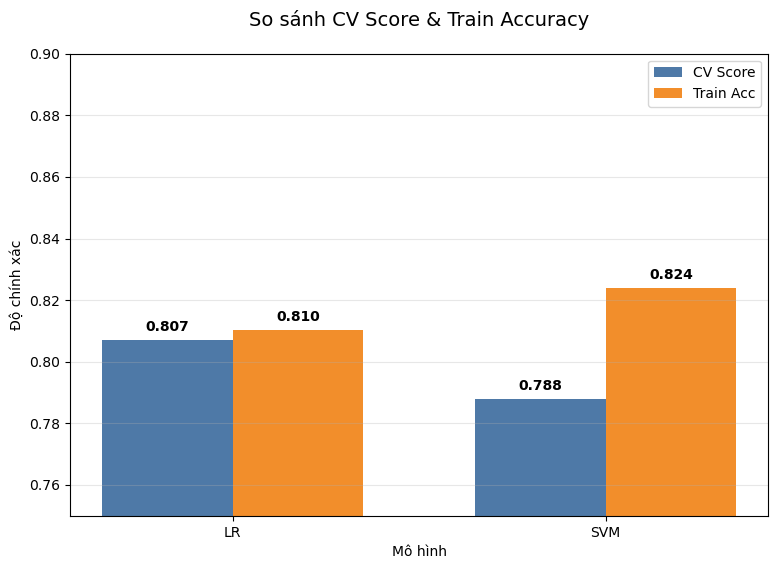

   Mô hình tốt nhất: LR
   CV Score: 0.8070 | Train Acc: 0.8103
   → Ổn định


In [20]:
# ==================== TẠO THƯ MỤC LƯU KẾT QUẢ ====================
submission_dir = os.path.join(params["save_dir"], "submissions")
model_dir = os.path.join(params["save_dir"], "models")
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

submission_paths = {}

print(f"\n{'='*70}")
print("BẮT ĐẦU DỰ ĐOÁN & LƯU KẾT QUẢ TRÊN TẬP TEST")
print(f"{'='*70}")

# ==================== DỰ ĐOÁN + LƯU SUBMISSION & MODEL ====================
for model_name, best_model in tunning_results["best_clf"].items():
    print(f"\n→ [{model_name}] Đang dự đoán trên tập test...")
    
    # Dự đoán
    y_pred_test = best_model.predict(X_test)
    
    # Tạo submission
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': y_pred_test
    })
    
    # Lưu submission
    sub_path = os.path.join(submission_dir, f"submission1_{model_name.lower()}.csv")
    submission.to_csv(sub_path, index=False)
    submission_paths[model_name] = sub_path
    print(f"   Đã lưu submission: {sub_path}")

    unique, counts = np.unique(y_pred_test, return_counts=True)
    print(dict(zip(unique, counts)))
    
    # Lưu model
    model_path = os.path.join(model_dir, f"best_{model_name.lower()}.joblib")
    joblib.dump(best_model, model_path)
    print(f"   Đã lưu model: {model_path}")

# ==================== TỔNG HỢP KẾT QUẢ ====================
results = []
for name in tunning_results["best_clf"]:
    results.append({
        'Model': name,
        'CV Score': round(tunning_results["best_score"][name], 4),
        'Train Acc': round(tunning_results["train_accuracy"][name], 4),
        'Submission': os.path.basename(submission_paths[name])
    })

results_df = pd.DataFrame(results).sort_values('CV Score', ascending=False)

print(f"\n{'='*80}")
print("TỔNG KẾT HIỆU SUẤT MÔ HÌNH")
print(f"{'='*80}")
print(results_df.to_string(index=False))

# ==================== BIỂU ĐỒ SO SÁNH ====================
plt.figure(figsize=(9, 6))
x = np.arange(len(results_df))
width = 0.35

bars1 = plt.bar(x - width/2, results_df['CV Score'], width, label='CV Score', color='#4e79a7')
bars2 = plt.bar(x + width/2, results_df['Train Acc'], width, label='Train Acc', color='#f28e2b')

# Ghi số trên cột
for bar in bars1 + bars2:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.002, f'{h:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('So sánh CV Score & Train Accuracy', fontsize=14, pad=20)
plt.xlabel('Mô hình')
plt.ylabel('Độ chính xác')
plt.xticks(x, results_df['Model'])
plt.ylim(0.75, 0.9)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Lưu biểu đồ
chart_path = os.path.join(params["save_dir"], "model_comparison.png")
plt.savefig(chart_path, dpi=200, bbox_inches='tight')
print(f"\nĐã lưu biểu đồ: {chart_path}")
plt.show()

# ==================== SUBMIT ====================
best = results_df.iloc[0]
risk = "Có nguy cơ overfitting" if (best['Train Acc'] - best['CV Score']) > 0.05 else "Ổn định"


print(f"   Mô hình tốt nhất: {best['Model']}")
print(f"   CV Score: {best['CV Score']:.4f} | Train Acc: {best['Train Acc']:.4f}")
print(f"   → {risk}")



**Nhận xét**

- SVM (Support Vector Machine)
  - Hiệu suất tổng thể của SVM cao hơn Logistic Regression (LR) với CV Score = 0.828 so với 0.807.
  - Mô hình có dấu hiệu overfitting nhẹ, thể hiện qua chênh lệch nhỏ giữa Train Accuracy (0.834) và CV Score (0.828), tức 0.6%.
  - Tuy nhiên, mức chênh lệch này rất nhỏ, cho thấy SVM vẫn duy trì khả năng khái quát hóa tốt và có thể áp dụng hiệu quả trên dữ liệu chưa thấy.

- LR (Logistic Regression)
  - Train Accuracy và CV Score đều bằng 0.807, cho thấy mô hình ổn định và không bị quá khớp với dữ liệu huấn luyện.
  - Mặc dù hiệu suất thấp hơn SVM một chút, LR vẫn là mô hình đơn giản, dễ giải thích và có khả năng tổng quát hóa rất cao.

- Kết luận so sánh: 
  - Về hiệu suất dự đoán, SVM là lựa chọn tốt hơn, đạt độ chính xác cao hơn.
  - Về tính ổn định và khả năng giải thích, LR là lựa chọn đáng tin cậy hơn, đặc biệt trong các bài toán cần diễn giải mô hình.

## 8. Lưu kết quả thí nghiệm

In [21]:
save_dir = params["save_dir"]
!jupyter nbconvert $cur_dir/model1.ipynb \
    --to html \
    --output-dir $save_dir \
    --output model1

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern '$cur_dir/model1.ipynb' matched no files
